In [1]:
# необходимые пакеты
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import itertools
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [2]:
df = pd.read_csv('./Data/train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [4]:
X_train.shape

(52500, 12)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [6]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [7]:
classifier1_1 = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C = 0.1,random_state = 42)),
])
classifier1_2 = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C = 10,random_state = 42)),
])

#запустим кросс-валидацию
cv_scores11 = cross_val_score(classifier1_1, X_train, y_train, cv=6, scoring='roc_auc')
cv_score11 = np.mean(cv_scores11)
cv_score_std11 = np.std(cv_scores11)

cv_scores12 = cross_val_score(classifier1_2, X_train, y_train, cv=6, scoring='roc_auc')
cv_score12 = np.mean(cv_scores12)
cv_score_std12 = np.std(cv_scores12)

print(f'CV score for model 1 LR 1 is {cv_score11}+-{cv_score_std11}')
print(f'CV score for model 2 LR 1 is {cv_score12}+-{cv_score_std12}')

#обучим пайплайн на всем тренировочном датасете
classifier1_1.fit(X_train, y_train)
y_score1 = classifier1_1.predict_proba(X_test)[:, 1]

classifier1_2.fit(X_train, y_train)
y_score2 = classifier1_2.predict_proba(X_test)[:, 1]

CV score for model 1 LR 1 is 0.7844374123135694+-0.005286474572634387
CV score for model 2 LR 1 is 0.7868698300824125+-0.004835306405044692


Посчитаем precision/recall/f_score

In [8]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score1)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('for y_score1: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
l1 = ['LogisticRegression_C=0.1', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score2)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('for y_score2: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
l2 = ['LogisticRegression_C=10', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]

for y_score1: Best Threshold=0.389193, F-Score=0.729, Precision=0.645, Recall=0.839
for y_score2: Best Threshold=0.386133, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

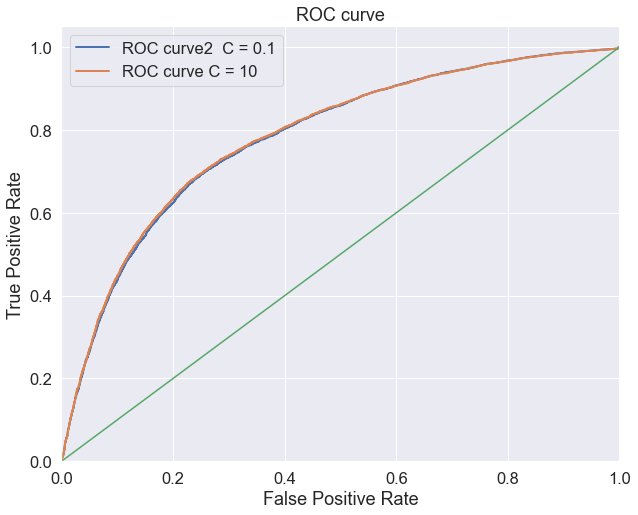

In [9]:
from sklearn import metrics
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ =  metrics.roc_curve(y_test, y_score1, pos_label = 1)# C = 0.1
fpr1, tpr1, thresholds_ = metrics.roc_curve(y_test, y_score2, pos_label = 1)#C = 10
lw = 2

plt.plot(fpr, tpr, lw=lw, label='ROC curve2  C = 0.1')
plt.plot(fpr1, tpr1, lw=lw, label='ROC curve C = 10')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("ROC.png")
plt.show()

*Кривая с С=10 незначительно лучше, т.к. расположена чуть выше и левее*

In [10]:
from sklearn.metrics import roc_auc_score, log_loss
roc_a_1 = roc_auc_score(y_true=y_test, y_score=classifier1_1.predict_proba(X_test)[:,1])
log_los1 = log_loss(y_true=y_test, y_pred=classifier1_1.predict_proba(X_test)[:,1])

roc_a_2 = roc_auc_score(y_true=1-y_test, y_score=classifier1_2.predict_proba(X_test)[:,0])
log_los2 = log_loss(y_true=1-y_test, y_pred=classifier1_2.predict_proba(X_test)[:,0])
#Ваш код здесь
print(f"roc auc score: {roc_a_1}")
print(f"log loss score: {log_los1}")
l1.append(format(roc_a_1, ".3f")), l1.append(format(log_los1, ".3f"))

#Ваш код здесь
print(f"roc auc score: {roc_a_2}")
print(f"log loss score: {log_los2}")
l2.append(format(roc_a_2, ".3f")), l2.append(format(log_los2, ".3f"))

roc auc score: 0.78198138395143
log loss score: 0.5793030705410785
roc auc score: 0.7842357780285694
log loss score: 0.5778392381903843


(None, None)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[ 565 8255]
 [  89 8591]]


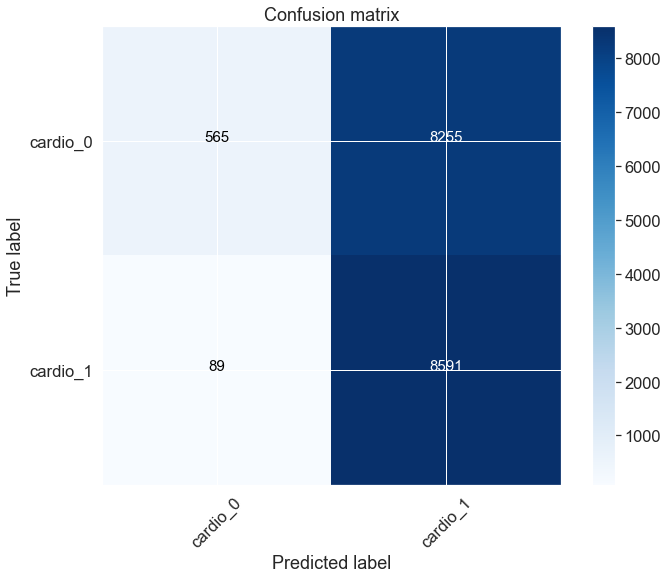

In [12]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

business_threshold = 0.386  # подберем порог для улучшения бизнесс показателя

cnf_matrix = confusion_matrix(y_test, y_score2>thresholds[ix]*business_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [13]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.9897465437788019, 0.9359410430839002, 0.06405895691609978)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

#### Пусть:
 - стоимость лечения 15000 р, если сделали тест и начали лечить вовремя
 - стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы 
 - стоимость теста 1400 р
 
 
 
 - лишних тестов сделали FP = cnf_matrix[0][1]
 - пропустили больных FN = cnf_matrix[1][0]
 - правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:

In [14]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000

In [15]:
rubl_1 = (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_late_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_1)

расходы, если не делать тест и ждать симптомов: 173600000


Расходы, если сделать тест всем:


In [16]:
rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test)

расходы, если делать тест всем и лечить группу большых: 154700000


Расходы если использовать ML:

In [17]:
rubl_ML = (cnf_matrix[0][1]+cnf_matrix[1][1]) * rubl_to_test + (cnf_matrix[1][0]) * rubl_to_late_treatment + np.sum(cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_ML)
l2.append(rubl_ML), l2.append(rubl_all_test - rubl_ML)

расходы, если не делать тест и ждать симптомов: 154229400


(None, None)

Оценим разницу:


In [18]:
print(' Расходы при решении не делать тесты - расходы с МL :',rubl_1 - rubl_ML )
print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',rubl_1 - rubl_all_test )
print(' Расходы сделать тесты всем - решение делать тесты ML  :',rubl_all_test - rubl_ML )

 Расходы при решении не делать тесты - расходы с МL : 19370600
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 470600


Метрика по деньгам : получить меньше расходов чем при полном тесте

Расходы на тестирование всех и лечение при ранней диагностике - расходы на ML тест и лечение при ранней диагностике группы TP и поздней диагностике группы FN

In [19]:
def business_threshold_calibrate(y_test, y_score, thresholds,rubl_to_test = 100, rubl_to_early_treatment = 100, rubl_to_late_treatment = 1000):
    business_threshold = 0
    r1_r2_ = 0
    r1_r3_ = 0
    r2_r3_ = 0
    rubl_1_ = - 10000000 
    rubl_all_test_ = - 10000000 
    rubl_ML_ = - 10000000 

    r2 = []
    n = 20
    for opt_buisness_tr in np.linspace(0,1,n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > ( opt_buisness_tr))
        #print(cnf_matrix )
        rubl_1 = ((cnf_matrix[1][1]+cnf_matrix[1][0])) * rubl_to_late_treatment

        rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + ((cnf_matrix[1][0]+cnf_matrix[1][1])) * rubl_to_early_treatment

        rubl_ML = ((cnf_matrix[1][1]+cnf_matrix[0][1])) * rubl_to_test + np.sum(cnf_matrix[1][0]) * rubl_to_late_treatment + (cnf_matrix[1][1]) * rubl_to_early_treatment
       
        r2_r3 = rubl_all_test - rubl_ML 
        
        r1_r2 = rubl_1 - rubl_all_test
        r1_r3 = rubl_1 - rubl_ML
        #print(opt_buisness_tr, r2_r3)
        if (r2_r3_ < r2_r3):
            
            business_threshold = opt_buisness_tr
            r1_r2_ = r1_r2
            r1_r3_ = r1_r3
            r2_r3_ = r2_r3
            rubl_1_ = rubl_1
            rubl_all_test_ = rubl_all_test
            rubl_ML_ = rubl_ML
            
        r2.append(r2_r3)   
            
    
    print('расходы, если не делать тест и ждать симптомов:',rubl_1_)
    print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test_)
    print('расходы, если не делать тест и ждать симптомов:',rubl_ML_)
    print(' Расходы при решении не делать тесты - расходы с МL :',r1_r3_ )
    print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',r1_r2_ )
    print(' Расходы сделать тесты всем - решение делать тесты ML  :',r2_r3_ )
    plt.plot(np.linspace(0,1,n),r2)
    plt.show()
    return business_threshold
    

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152707200
 Расходы при решении не делать тесты - расходы с МL : 20892800
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 1992800


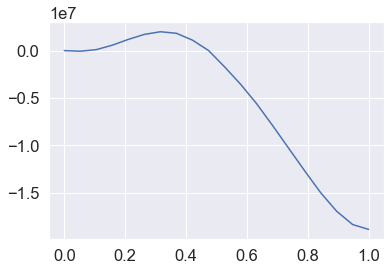

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.38613305436826423


In [20]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score2, 
                                          thresholds[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[ix])

## Бустинг регрессор

In [21]:
%%time
gb_model1 = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=4,
                                     random_state=42,  
                                     n_estimators=150)

gb_model2 = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=8,
                                     random_state=42,  
                                     n_estimators=100)

gb_model3 = GradientBoostingRegressor(criterion='mse',
                                     max_depth=9,
                                     min_samples_leaf=8,
                                     random_state=42,  
                                     n_estimators=100)

classifier21 = Pipeline([
    ('features',feats),
    ('classifier', gb_model1),
])
classifier22 = Pipeline([
    ('features',feats),
    ('classifier', gb_model2),
])
classifier23 = Pipeline([
    ('features',feats),
    ('classifier', gb_model3),
])

#запустим кросс-валидацию
cv_scores21 = cross_val_score(classifier21, X_train, y_train, cv=6, scoring='roc_auc')
cv_score21 = np.mean(cv_scores21)
cv_score_std21 = np.std(cv_scores21)

cv_scores22 = cross_val_score(classifier22, X_train, y_train, cv=6, scoring='roc_auc')
cv_score22 = np.mean(cv_scores22)
cv_score_std22 = np.std(cv_scores22)

cv_scores23 = cross_val_score(classifier23, X_train, y_train, cv=6, scoring='roc_auc')
cv_score23 = np.mean(cv_scores23)
cv_score_std23 = np.std(cv_scores23)

print(f'GB score for gb_model1 is {cv_score21}+-{cv_score_std21}')
print(f'GB score for gb_model2 is {cv_score22}+-{cv_score_std22}')
print(f'GB score for gb_model3 is {cv_score23}+-{cv_score_std23}')

#обучим пайплайн на всем тренировочном датасете
classifier21.fit(X_train, y_train)
classifier22.fit(X_train, y_train)
classifier23.fit(X_train, y_train)

y_train_preds1 = classifier21.predict(X_train)
y_test_preds1 = classifier21.predict(X_test)

y_train_preds2 = classifier22.predict(X_train)
y_test_preds2 = classifier22.predict(X_test)

y_train_preds3 = classifier23.predict(X_train)
y_test_preds3 = classifier23.predict(X_test)

GB score for gb_model1 is 0.7999135197904951+-0.004224545059933428
GB score for gb_model2 is 0.7995443620579638+-0.0038888253243289225
GB score for gb_model3 is 0.7952925021168541+-0.0035881470713918936
Wall time: 3min 13s


Посчитаем precision/recall/f_score

In [22]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_test_preds1)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('для y_test_preds1: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
l3 = ['GradientBoostingRegressor_maxdepth=12', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]


precision, recall, thresholds = precision_recall_curve(y_test.values, y_test_preds2)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('для y_test_preds2: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
l4 = ['GradientBoostingRegressor_maxdepth=7', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]


precision, recall, thresholds = precision_recall_curve(y_test.values, y_test_preds3)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('для y_test_preds3: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
l5 = ['GradientBoostingRegressor_maxdepth=9', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]



для y_test_preds1: Best Threshold=0.370801, F-Score=0.740, Precision=0.678, Recall=0.815
для y_test_preds2: Best Threshold=0.357747, F-Score=0.741, Precision=0.670, Recall=0.828
для y_test_preds3: Best Threshold=0.363724, F-Score=0.738, Precision=0.672, Recall=0.818


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

In [23]:
def roc_curve_gb(y_score1, y_score2, y_score3):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    
    fpr3, tpr3, thresholds_ = metrics.roc_curve(y_test, y_score1, pos_label=1)# max_depth=12
    fpr2, tpr2, thresholds_ = metrics.roc_curve(y_test, y_score2, pos_label=1)#max_depth=7
    fpr4, tpr4, thresholds_ = metrics.roc_curve(y_test, y_score3, pos_label=1)#max_depth=9
    lw = 3

    plt.plot(fpr3, tpr3, lw=lw, label='ROC curve max_depth=12')
    plt.plot(fpr2, tpr2, lw=lw, label='ROC curve1 max_depth=7')
    plt.plot(fpr4, tpr4, lw=lw, label='ROC curve max_depth=9')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.savefig("ROC.png")
    plt.show()

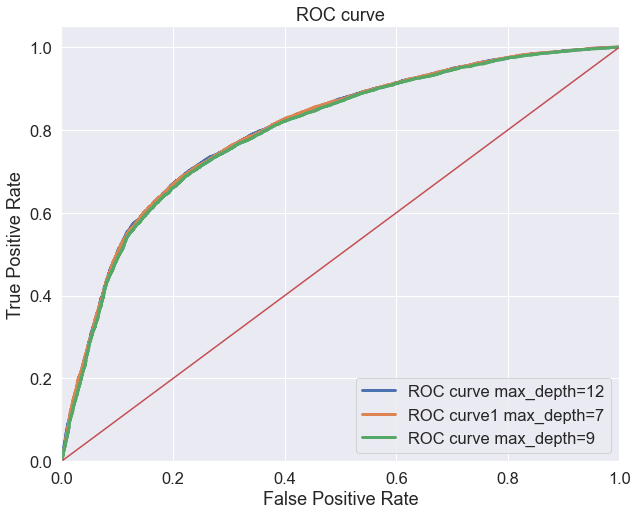

In [24]:
roc_curve_gb(y_test_preds1, y_test_preds2, y_test_preds3)

лучше себя показала моделька с максимальной глубиной 7, ее порог составляет 0,357

In [25]:
from sklearn.metrics import roc_auc_score, log_loss
gb_1_roc = roc_auc_score(y_true=y_test, y_score=classifier21.predict(X_test))
gb_2_roc = roc_auc_score(y_true=y_test, y_score=classifier22.predict(X_test))
gb_3_roc = roc_auc_score(y_true=y_test, y_score=classifier23.predict(X_test))

gb_1_logloss = log_loss(y_true=y_test, y_pred=classifier21.predict(X_test))
gb_2_logloss = log_loss(y_true=y_test, y_pred=classifier22.predict(X_test))
gb_3_logloss = log_loss(y_true=y_test, y_pred=classifier23.predict(X_test))

l3.append(format(gb_1_roc, ".3f")), l3.append(format(gb_1_logloss, ".3f"))
l4.append(format(gb_2_roc, ".3f")), l4.append(format(gb_2_logloss, ".3f"))
l5.append(format(gb_3_roc, ".3f")), l5.append(format(gb_3_logloss, ".3f"))

#Ваш код здесь
print(f'roc auc score для GB: {gb_2_roc}')
print(f'log loss score  для GB: {gb_2_logloss}')

roc auc score для GB: 0.8005444658662236
log loss score  для GB: 0.5443377343760911


*показатель roc auc улучшился на данной модели с 0,78 до 0,8.*

Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[1210 7610]
 [ 121 8559]]


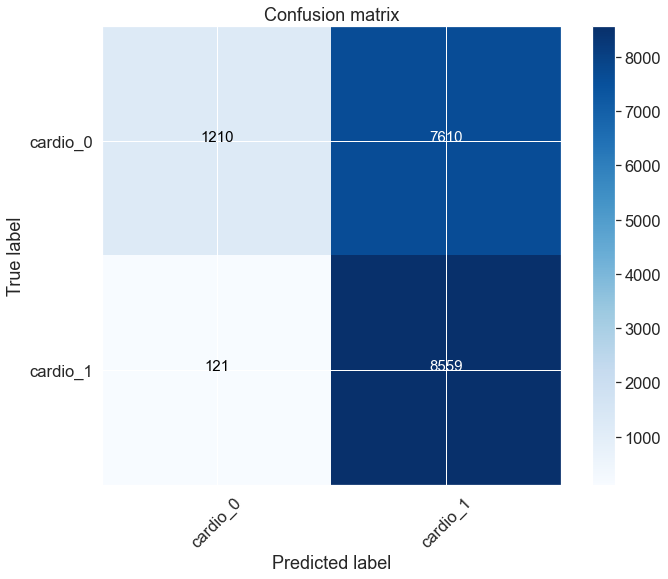

In [26]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

business_threshold = 0.357  # подберем порог для улучшения бизнесс показателя
# y_score
cnf_matrix = confusion_matrix(y_test, y_test_preds2>thresholds[ix]*business_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [27]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.9860599078341014, 0.86281179138322, 0.13718820861678005)

*False Positive Rate значительно увеличился с 0,45 до 0,86, при этом True Positive Rate улучшил показатели и вырос с 0,83 до 0,98.*

*Это означает, что 86 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы*

#### Пусть:
 - стоимость лечения 15000 р, если сделали тест и начали лечить вовремя
 - стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы 
 - стоимость теста 1400 р
 
 
 
 - лишних тестов сделали FP = cnf_matrix[0][1]
 - пропустили больных FN = cnf_matrix[1][0]
 - правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:

In [28]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000

In [29]:
rubl_2 = (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_late_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_2)

расходы, если не делать тест и ждать симптомов: 173600000


Расходы, если сделать тест всем:


In [30]:
rubl_all_test_2 = np.sum(cnf_matrix) * rubl_to_test + (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test)

расходы, если делать тест всем и лечить группу большых: 154700000


Расходы если использовать ML:

In [31]:
rubl_ML_2 = (cnf_matrix[0][1]+cnf_matrix[1][1]) * rubl_to_test + (cnf_matrix[1][0]) * rubl_to_late_treatment + np.sum(cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_ML_2)

расходы, если не делать тест и ждать симптомов: 153441600


Оценим разницу:


In [32]:
print(' Расходы при решении не делать тесты - расходы с МL :',rubl_2 - rubl_ML_2 )
print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',rubl_2 - rubl_all_test_2 )
print(' Расходы сделать тесты всем - решение делать тесты ML  :',rubl_all_test_2 - rubl_ML_2 )

l4.append(rubl_ML_2), l4.append(rubl_all_test_2 - rubl_ML_2)

 Расходы при решении не делать тесты - расходы с МL : 20158400
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 1258400


(None, None)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152433400
 Расходы при решении не делать тесты - расходы с МL : 21166600
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 2266600


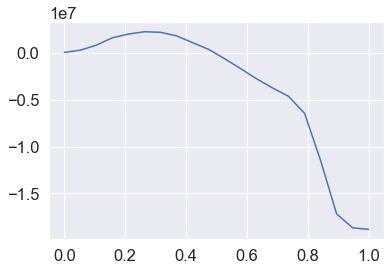

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.36372392808315407


In [33]:
BUisnes_tr = business_threshold_calibrate(y_test, y_test_preds2, 
                                          thresholds[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[ix])

## Бустинг классификация

In [34]:
from sklearn.ensemble import GradientBoostingClassifier


clf1 = GradientBoostingClassifier(n_estimators=150,  # кол-во деревьев
                                 learning_rate=0.8, #скорость обучения
                                 max_depth=6, # максимальная глубина
                                 random_state=3)

clf2 = GradientBoostingClassifier(n_estimators=50,  # кол-во деревьев
                                 learning_rate=0.1, #скорость обучения
                                 max_depth=6, # максимальная глубина
                                 random_state=3)

clf3 = GradientBoostingClassifier(n_estimators=150,  # кол-во деревьев
                                 learning_rate=0.01, #скорость обучения
                                 max_depth=6, # максимальная глубина
                                 random_state=3)


classifier4_1 = Pipeline([
    ('features',feats),
    ('classifier', clf1),
])

classifier4_2 = Pipeline([
    ('features',feats),
    ('classifier', clf2),
])

classifier4_3 = Pipeline([
    ('features',feats),
    ('classifier', clf3),
])

#запустим кросс-валидацию
cv_scores41 = cross_val_score(classifier4_1, X_train, y_train, cv=6, scoring='roc_auc')
cv_score41 = np.mean(cv_scores41)
cv_score_std41 = np.std(cv_scores41)

cv_scores42 = cross_val_score(classifier4_2, X_train, y_train, cv=6, scoring='roc_auc')
cv_score42 = np.mean(cv_scores42)
cv_score_std42 = np.std(cv_scores42)

cv_scores43 = cross_val_score(classifier4_3, X_train, y_train, cv=6, scoring='roc_auc')
cv_score43 = np.mean(cv_scores43)
cv_score_std43 = np.std(cv_scores43)

print(f'GB 1 is {cv_score41} +  {cv_score_std41}')
print(f'GB 2 is {cv_score42} +  {cv_score_std42}')
print(f'GB 3 is {cv_score43} +  {cv_score_std43}')

#обучим пайплайн на всем тренировочном датасете
classifier4_1.fit(X_train, y_train)
classifier4_2.fit(X_train, y_train)
classifier4_3.fit(X_train, y_train)

y_train_clf_1 = classifier4_1.predict(X_train)
y_test_clf_1 = classifier4_1.predict(X_test)

y_train_clf_2 = classifier4_2.predict(X_train)
y_test_clf_2 = classifier4_2.predict(X_test)

y_train_clf_3 = classifier4_3.predict(X_train)
y_test_clf_3 = classifier4_3.predict(X_test)

GB 1 is 0.7466308473438712 +  0.0040885091208871125
GB 2 is 0.8021240702895076 +  0.0038448857523661843
GB 3 is 0.800323295524712 +  0.003591455951507891


Посчитаем precision/recall/f_score

In [35]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_test_clf_1)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('для y_test_clf_1: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

l6 = ['GradientBoostingClassifier_1', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]


precision, recall, thresholds = precision_recall_curve(y_test.values, y_test_clf_2)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('для y_test_clf_2: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

l7 = ['GradientBoostingClassifier_2', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]


precision, recall, thresholds = precision_recall_curve(y_test.values, y_test_clf_3)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('для y_test_clf_3: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

l8 = ['GradientBoostingClassifier_3', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]


для y_test_clf_1: Best Threshold=1.000000, F-Score=0.686, Precision=0.710, Recall=0.664
для y_test_clf_2: Best Threshold=1.000000, F-Score=0.722, Precision=0.758, Recall=0.689
для y_test_clf_3: Best Threshold=1.000000, F-Score=0.716, Precision=0.763, Recall=0.675


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

In [36]:
def roc_curve(y_score1, y_score2, y_score3):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    
    fpr3, tpr3, thresholds_ = metrics.roc_curve(y_test, y_score1, pos_label=1)# 
    fpr2, tpr2, thresholds_ = metrics.roc_curve(y_test, y_score2, pos_label=1)#
    fpr4, tpr4, thresholds_ = metrics.roc_curve(y_test, y_score3, pos_label=1)#
    lw = 3

    plt.plot(fpr2, tpr2, lw=lw, label='ROC curve1')
    plt.plot(fpr3, tpr3, lw=lw, label='ROC curve2')
    plt.plot(fpr4, tpr4, lw=lw, label='ROC curve3')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.savefig("ROC.png")
    plt.show()

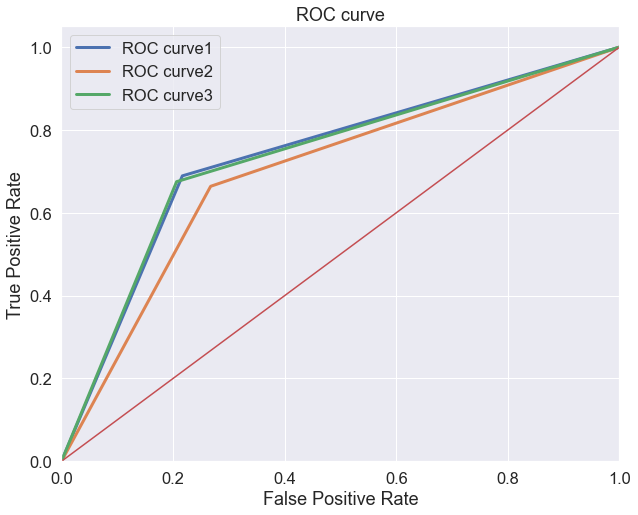

In [37]:
roc_curve(y_test_clf_1, y_test_clf_2, y_test_clf_3)

на графике 1 и 3 модельки между собой похожи. Но показатель F-score лучше у второй модельки

In [38]:
from sklearn.metrics import roc_auc_score, log_loss
clf_1_roc = roc_auc_score(y_true=y_test, y_score=classifier21.predict(X_test))
clf_2_roc = roc_auc_score(y_true=y_test, y_score=classifier22.predict(X_test))
clf_3_roc = roc_auc_score(y_true=y_test, y_score=classifier23.predict(X_test))

clf_1_logloss = log_loss(y_true=y_test, y_pred=classifier21.predict(X_test))
clf_2_logloss = log_loss(y_true=y_test, y_pred=classifier22.predict(X_test))
clf_3_logloss = log_loss(y_true=y_test, y_pred=classifier23.predict(X_test))

l6.append(format(clf_1_roc, ".3f")), l6.append(format(clf_1_logloss, ".3f"))
l7.append(format(clf_2_roc, ".3f")), l7.append(format(clf_2_logloss, ".3f"))
l8.append(format(clf_3_roc, ".3f")), l8.append(format(clf_3_logloss, ".3f"))

#Ваш код здесь
print(f'roc auc score для GB: {clf_2_roc}')
print(f'log loss score  для GB: {clf_2_logloss}')

roc auc score для GB: 0.8005444658662236
log loss score  для GB: 0.5443377343760911


Confusion matrix, without normalization
[[6909 1911]
 [2698 5982]]


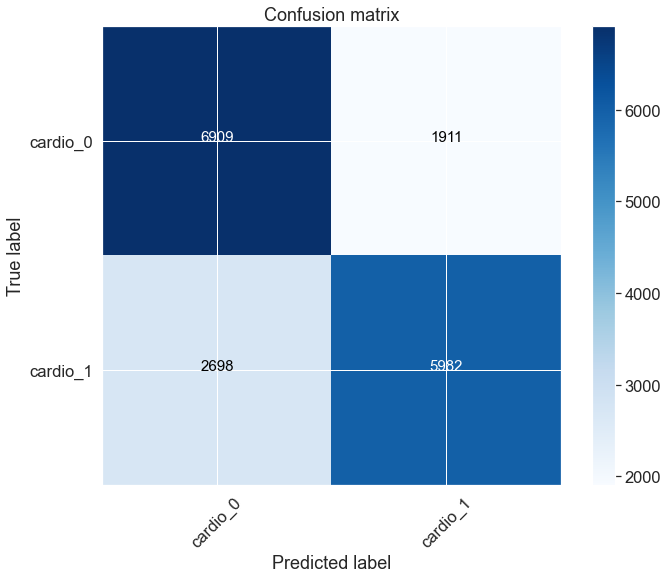

In [39]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

business_threshold = 0.999  # подберем порог для улучшения бизнесс показателя
# y_score
cnf_matrix = confusion_matrix(y_test, y_test_clf_2>thresholds[ix]*business_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [40]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.6891705069124424, 0.21666666666666667, 0.7833333333333333)

*False Positive Rate снизился с 0,45 до 0,21*

*Это означает, что 21 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы*

In [41]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000

In [42]:
rubl = (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_late_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl)

расходы, если не делать тест и ждать симптомов: 173600000


Расходы, если сделать тест всем:


In [43]:
rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если делать тест всем и лечить группу большых:', rubl_all_test)

расходы, если делать тест всем и лечить группу большых: 154700000


Расходы если использовать ML:

In [44]:
rubl_ML = (cnf_matrix[0][1]+cnf_matrix[1][1]) * rubl_to_test + (cnf_matrix[1][0]) * rubl_to_late_treatment + np.sum(cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_ML)

расходы, если не делать тест и ждать симптомов: 154740200


Оценим разницу:


In [45]:
print(' Расходы при решении не делать тесты - расходы с МL :',rubl - rubl_ML )
print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',rubl - rubl_all_test )
print(' Расходы сделать тесты всем - решение делать тесты ML  :',rubl_all_test - rubl_ML )

l7.append(rubl_ML), l7.append(rubl_all_test - rubl_ML)

 Расходы при решении не делать тесты - расходы с МL : 18859800
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : -40200


(None, None)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152433400
 Расходы при решении не делать тесты - расходы с МL : 21166600
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 2266600


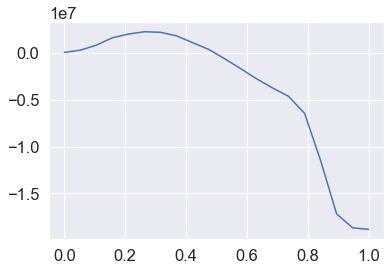

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 1


In [46]:
BUisnes_tr = business_threshold_calibrate(y_test, y_test_preds2, 
                                          thresholds[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[ix])

## Случайный лес

In [47]:
%%time
rf_model_1 = RandomForestRegressor(criterion='mse',
                                 max_depth=15, # глубина дерева  
                                 min_samples_leaf=4, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42, 
                                 n_estimators=200  # кол-во деревьев
                                 )

rf_model_2 = RandomForestRegressor(criterion='mse',
                                 max_depth=10, # глубина дерева  
                                 min_samples_leaf=2, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42, 
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model_3 = RandomForestRegressor(criterion='mse',
                                 max_depth=15, # глубина дерева  
                                 min_samples_leaf=5, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42, 
                                 n_estimators=350  # кол-во деревьев
                                 )


classifier3_1 = Pipeline([
    ('features',feats),
    ('classifier', rf_model_1),
]) 

classifier3_2 = Pipeline([
    ('features',feats),
    ('classifier', rf_model_2),
]) 

classifier3_3 = Pipeline([
    ('features',feats),
    ('classifier', rf_model_3),
])

#запустим кросс-валидацию
cv_scores31 = cross_val_score(classifier3_1, X_train, y_train, cv=6, scoring='roc_auc')
cv_score31 = np.mean(cv_scores31)
cv_score_std31 = np.std(cv_scores31)

cv_scores32 = cross_val_score(classifier3_2, X_train, y_train, cv=6, scoring='roc_auc')
cv_score32 = np.mean(cv_scores32)
cv_score_std32 = np.std(cv_scores32)

cv_scores33 = cross_val_score(classifier3_3, X_train, y_train, cv=6, scoring='roc_auc')
cv_score33 = np.mean(cv_scores33)
cv_score_std33 = np.std(cv_scores33)

print(f'RForest 1 is {cv_score31} +  {cv_score_std31}')
print(f'RForest 2 is {cv_score32} +  {cv_score_std32}')
print(f'RForest 3 is {cv_score33} +  {cv_score_std33}')

#обучим пайплайн на всем тренировочном датасете
classifier3_1.fit(X_train, y_train)
classifier3_2.fit(X_train, y_train)
classifier3_3.fit(X_train, y_train)

y_train_rf_1 = classifier3_1.predict(X_train)
y_test_rf_1 = classifier3_1.predict(X_test)

y_train_rf_2 = classifier3_2.predict(X_train)
y_test_rf_2 = classifier3_2.predict(X_test)

y_train_rf_3 = classifier3_3.predict(X_train)
y_test_rf_3 = classifier3_3.predict(X_test)

RForest 1 is 0.7954045557358037 +  0.004491766936820075
RForest 2 is 0.7996033134415034 +  0.004477609562631532
RForest 3 is 0.7958019916708642 +  0.0044894381953514435
Wall time: 6min 5s


Посчитаем precision/recall/f_score

In [48]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_test_rf_1)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('для y_test_rf_1: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
l9 = ['RandomForestRegressor_1', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]


precision, recall, thresholds = precision_recall_curve(y_test.values, y_test_rf_2)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('для y_test_rf_2: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
l10 = ['RandomForestRegressor_2', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]

precision, recall, thresholds = precision_recall_curve(y_test.values, y_test_rf_3)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('для y_test_rf_3: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
l11 = ['RandomForestRegressor_3', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f")]

для y_test_rf_1: Best Threshold=0.369926, F-Score=0.738, Precision=0.678, Recall=0.810
для y_test_rf_2: Best Threshold=0.357675, F-Score=0.740, Precision=0.671, Recall=0.824
для y_test_rf_3: Best Threshold=0.394123, F-Score=0.737, Precision=0.694, Recall=0.785


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

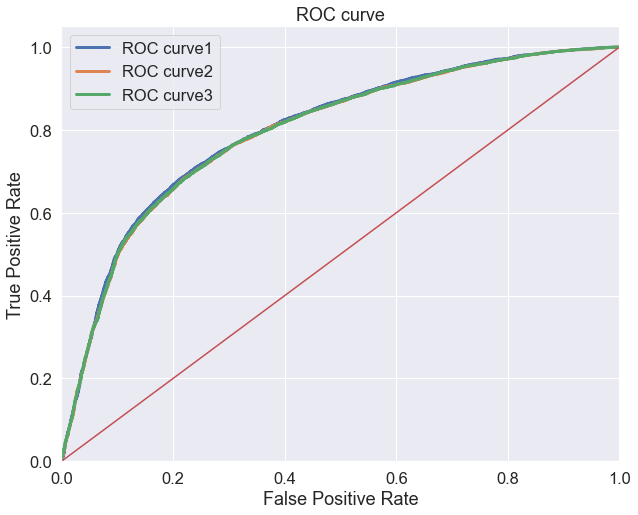

In [49]:
roc_curve(y_test_rf_1, y_test_rf_2, y_test_rf_3)

In [50]:
from sklearn.metrics import roc_auc_score, log_loss
rfr_1_roc = roc_auc_score(y_true=y_test, y_score=classifier3_1.predict(X_test))
rfr_2_roc = roc_auc_score(y_true=y_test, y_score=classifier3_2.predict(X_test))
rfr_3_roc = roc_auc_score(y_true=y_test, y_score=classifier3_3.predict(X_test))

rfr_1_logloss = log_loss(y_true=y_test, y_pred=classifier3_1.predict(X_test))
rfr_2_logloss = log_loss(y_true=y_test, y_pred=classifier3_2.predict(X_test))
rfr_3_logloss = log_loss(y_true=y_test, y_pred=classifier3_3.predict(X_test))

l9.append(format(rfr_1_roc, ".3f")), l9.append(format(rfr_1_logloss, ".3f"))
l10.append(format(rfr_2_roc, ".3f")), l10.append(format(rfr_2_logloss, ".3f"))
l11.append(format(rfr_3_roc, ".3f")), l11.append(format(rfr_3_logloss, ".3f"))

print(f'roc auc score для RF: {roc_auc_score(y_true=y_test, y_score=classifier3_2.predict(X_test))}')
print(f'log loss score  для RF: {log_loss(y_true=y_test, y_pred=classifier3_2.predict(X_test))}')

roc auc score для RF: 0.7992600016196956
log loss score  для RF: 0.5429849963857107


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[1204 7616]
 [ 124 8556]]


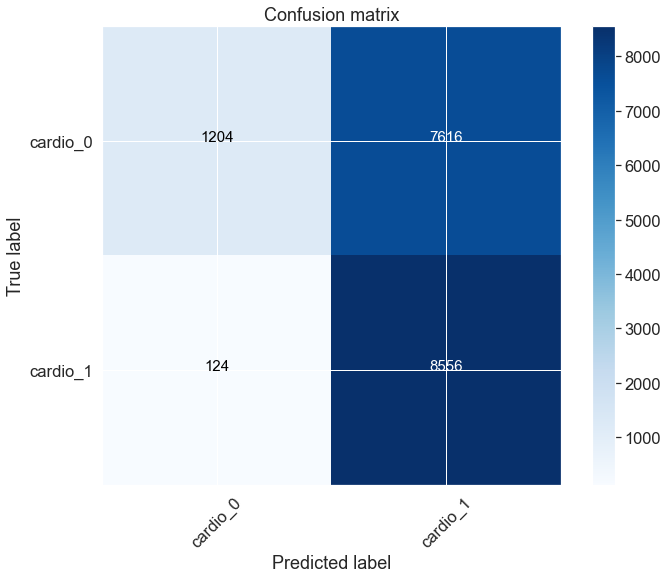

In [51]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

business_threshold = 0.357  # подберем порог для улучшения бизнесс показателя
# y_score
cnf_matrix = confusion_matrix(y_test, y_test_rf_2>thresholds[ix]*business_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [52]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.9857142857142858, 0.8634920634920635, 0.1365079365079365)

*False Positive Rate слишком сильно увеличился до 0,86.*

*Это означает, что 86 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы*

#### Пусть:
 - стоимость лечения 15000 р, если сделали тест и начали лечить вовремя
 - стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы 
 - стоимость теста 1400 р
 
 
 
 - лишних тестов сделали FP = cnf_matrix[0][1]
 - пропустили больных FN = cnf_matrix[1][0]
 - правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:

In [53]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000

In [54]:
rubl = (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_late_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl)

расходы, если не делать тест и ждать симптомов: 173600000


Расходы, если сделать тест всем:


In [55]:
rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test)

расходы, если делать тест всем и лечить группу большых: 154700000


Расходы если использовать ML:

In [56]:
rubl_ML = (cnf_matrix[0][1]+cnf_matrix[1][1]) * rubl_to_test + (cnf_matrix[1][0]) * rubl_to_late_treatment + np.sum(cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_ML)

расходы, если не делать тест и ждать симптомов: 153460800


Оценим разницу:


In [57]:
print(' Расходы при решении не делать тесты - расходы с МL :',rubl - rubl_ML )
print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',rubl - rubl_all_test )
print(' Расходы сделать тесты всем - решение делать тесты ML  :',rubl_all_test - rubl_ML )

l10.append(rubl_ML), l10.append(rubl_all_test - rubl_ML)

 Расходы при решении не делать тесты - расходы с МL : 20139200
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 1239200


(None, None)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152464200
 Расходы при решении не делать тесты - расходы с МL : 21135800
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 2235800


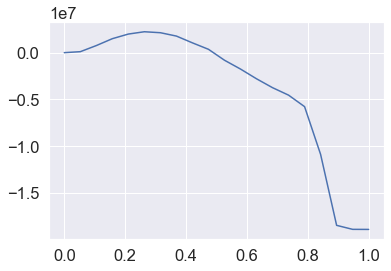

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.39412287855284994


In [58]:
BUisnes_tr = business_threshold_calibrate(y_test, y_test_rf_2, 
                                          thresholds[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[ix])

In [59]:
metrics_list = []
metrics_list.append(l1), metrics_list.append(l2), metrics_list.append(l3), metrics_list.append(l4), metrics_list.append(l5), 
metrics_list.append(l6), metrics_list.append(l7), metrics_list.append(l8), metrics_list.append(l9),
metrics_list.append(l10), metrics_list.append(l11)
metrics_list = pd.DataFrame(metrics_list, columns=['type', 'Best Threshold', 'F-Score', 'Precision', 'Recall', 'roc_auc', 'log loss', 'rubl_ML', 'rubl_all_test - rubl_ML'])

In [60]:
metrics_list.head(11)

,type,Best Threshold,F-Score,Precision,Recall,roc_auc,log loss,rubl_ML,rubl_all_test - rubl_ML
0,LogisticRegression_C=0.1,0.389,0.729,0.645,0.839,0.782,0.579,NaN,NaN
1,LogisticRegression_C=10,0.386,0.730,0.647,0.838,0.784,0.578,154229400.0,470600.0
2,GradientBoostingRegressor_maxdepth=12,0.371,0.740,0.678,0.815,0.801,0.560,NaN,NaN
3,GradientBoostingRegressor_maxdepth=7,0.358,0.741,0.670,0.828,0.801,0.544,153441600.0,1258400.0
4,GradientBoostingRegressor_maxdepth=9,0.364,0.738,0.672,0.818,0.796,0.577,NaN,NaN
5,GradientBoostingClassifier_1,1.000,0.686,0.710,0.664,0.801,0.560,NaN,NaN
6,GradientBoostingClassifier_2,1.000,0.722,0.758,0.689,0.801,0.544,154740200.0,-40200.0
7,GradientBoostingClassifier_3,1.000,0.716,0.763,0.675,0.796,0.577,NaN,NaN
8,RandomForestRegressor_1,0.370,0.738,0.678,0.810,0.795,0.549,NaN,NaN
9,RandomForestRegressor_2,0.358,0.740,0.671,0.824,0.799,0.543,153460800.0,1239200.0


думаю, что лучше всего себя показала модель GradientBoostingClassifier_2, т.к. разница Расходы сделать тесты всем - решение делать тесты ML - 40 200